In [78]:
import pickle
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import math
import pandas as pd
import csv

Pareto front

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


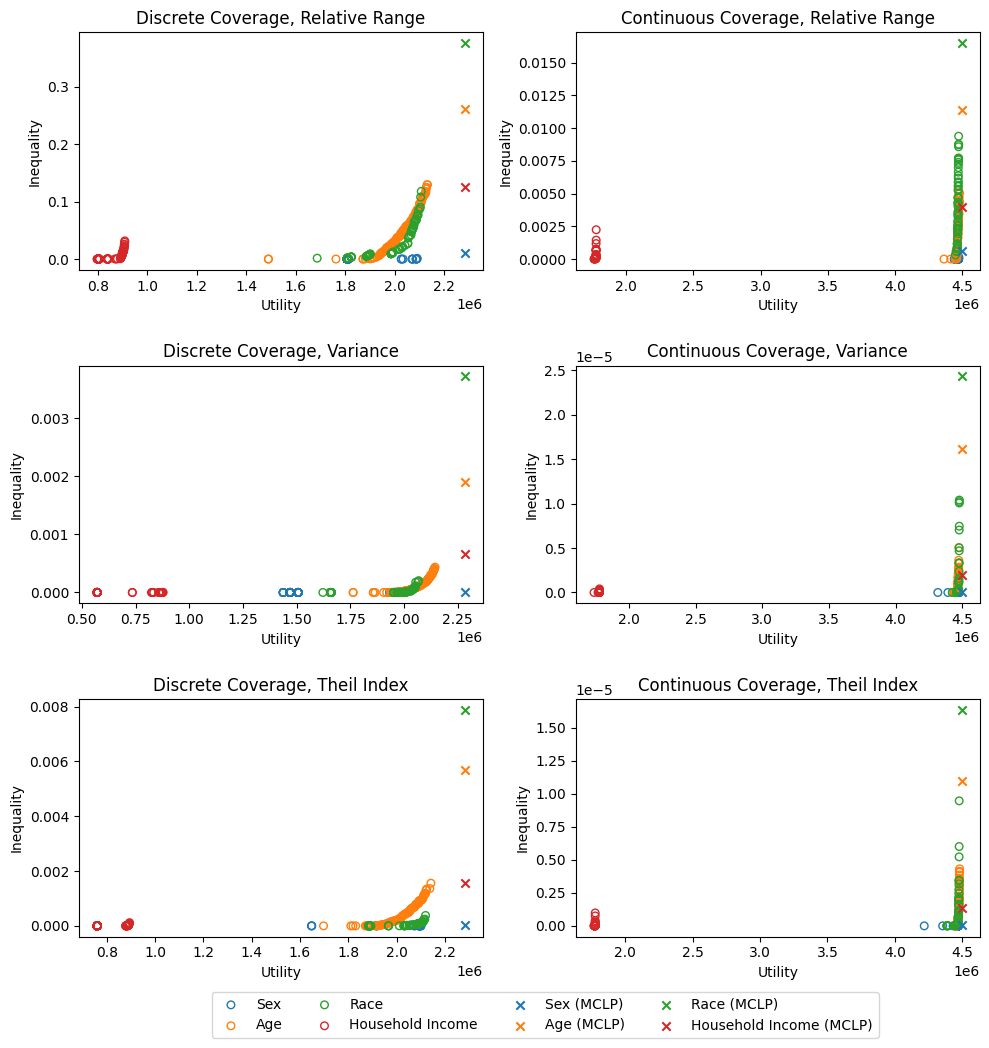

In [58]:
C = ["Discrete Coverage", "Continuous Coverage"]
G1 = ["Sex", "Age", "Race", "Household Income"]
G2 = ["Sex (MCLP)", "Age (MCLP)", "Race (MCLP)", "Household Income (MCLP)"]
P = ["Relative Range", "Variance", "Theil Index"]

# colors = ['red', 'green', 'blue', 'yellow']
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for idx_c, cov in enumerate(C):
    for idx_p, prob in enumerate(P):
        ax = axs[idx_p, idx_c]
        for idx_g, groups in enumerate(G1):
            F = pickle.load(open('data/obj/F_cov' + str(idx_c+1) + '_grp' + str(idx_g) + '_prob' + str(idx_p+1) + '.pickle', "rb"))
            ax.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors=cmap(idx_g), label=groups)
        for idx_g, groups in enumerate(G2):
            F_mclp = pickle.load(open('data/obj/F_cov' + str(idx_c+1) + '_grp' + str(idx_g) + '.pickle', "rb"))
            ax.scatter(-F_mclp[0], F_mclp[idx_p+1], color=cmap(idx_g), marker='x', label=groups)
        ax.set_title(f"{cov}, {prob}")
        ax.set_xlabel("Utility")
        ax.set_ylabel("Inequality")

fig.legend(G1 + G2, loc='lower center', bbox_to_anchor=(0.55, -0.05), ncol=4)
plt.tight_layout()
# plt.savefig("pareto_front.png", format="png", bbox_inches='tight')
plt.savefig("pareto_front.eps", format="eps", bbox_inches='tight')
plt.show()


Socioeconomics (race)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


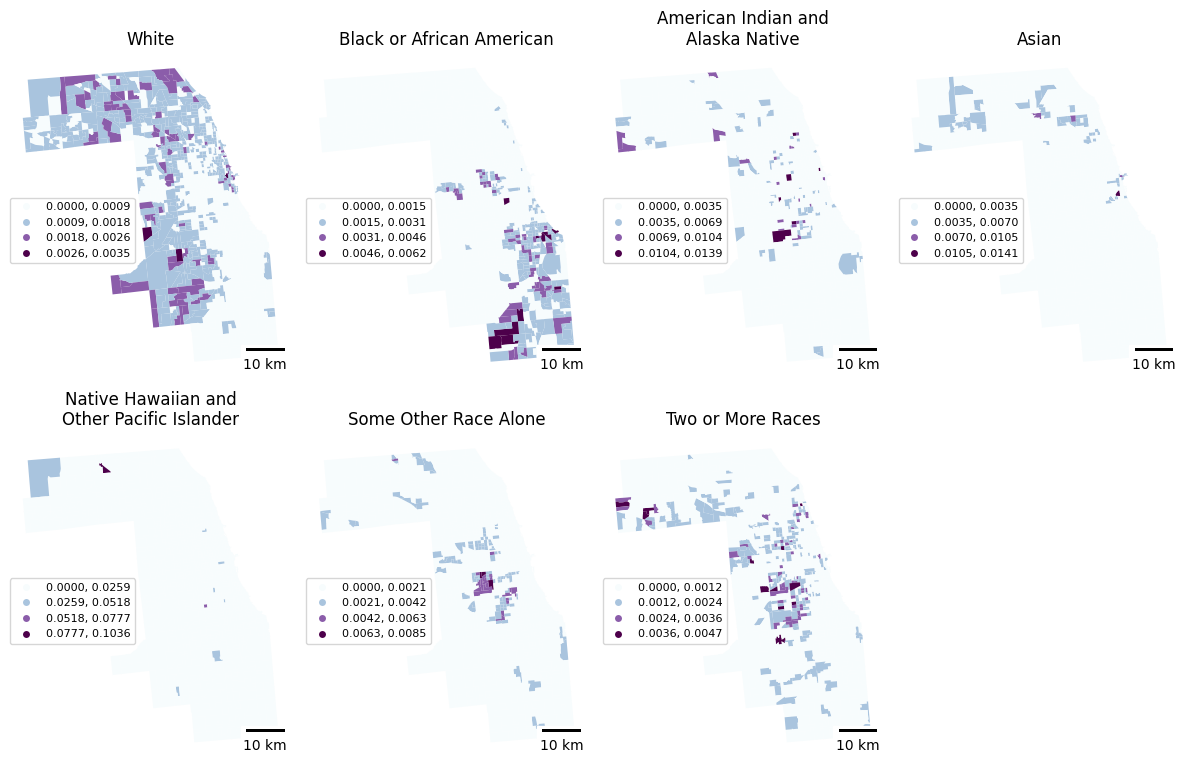

In [57]:
cook = gpd.read_file('data/cook_tract_all.shp')
G = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
R = ['White', 'Black or African American', 'American Indian and\nAlaska Native', 'Asian', 'Native Hawaiian and\nOther Pacific Islander', 'Some Other Race Alone', 'Two or More Races']

num_cols = 4
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, column_name in enumerate(G):
    normalized_column_name = f"{column_name}_p"
    cook[normalized_column_name] = cook[column_name] / sum(cook[column_name])

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    ax = axs[row_idx, col_idx]
    cook.plot(column=normalized_column_name, scheme="equal_interval", k=4, cmap="BuPu", ax=ax, 
              legend=True, legend_kwds={"loc": "lower left", "bbox_to_anchor": (0, 0.35), 'fontsize': 8, 'markerscale': 0.5, 'fmt': "{:.4f}", 'borderaxespad': 0})
    ax.set_title(R[idx])
    ax.set_axis_off()
    scalebar = ScaleBar(1, location='lower right')
    ax.add_artist(scalebar)

for idx in range(len(G), num_cols * num_rows):
    axs.flatten()[idx].remove()

plt.tight_layout()
plt.savefig("race.png", format="png", bbox_inches='tight')
plt.savefig("race.eps", format="eps", bbox_inches='tight')
plt.show()

Sensor placement (race)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


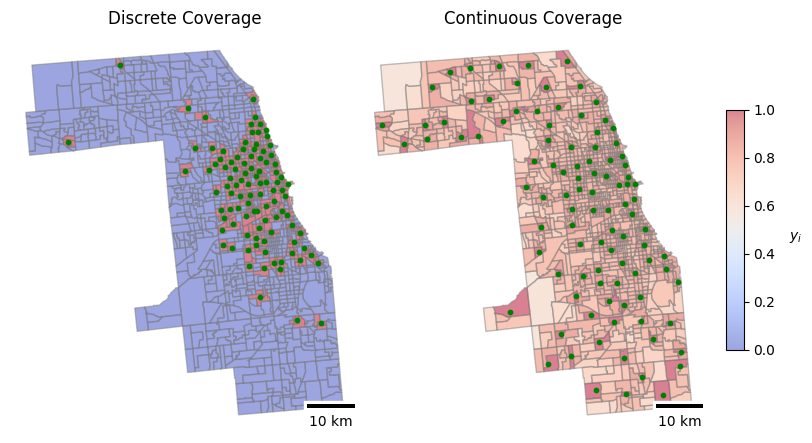

In [9]:
# MCLP
s = 1000
t = 0.1

cook_centroids = gpd.read_file('data/cook_centroids_all.shp')
cook = gpd.read_file('data/cook_tract_all.shp')
n1 = cook_centroids.shape[0]

# discrete coverage
def coverage_discrete(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            if D[i, j] <= s:
                A[i, j] = 1
    return A

# continuous coverage
def coverage_continuous(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            A[i, j] = math.exp(-t * D[i, j] / s)
    return A

# distance matrix
points = cook_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
D = cdist(points, points, metric='euclidean')

C = {
    1: coverage_discrete,
    2: coverage_continuous
}
C_labels = ["Discrete Coverage", "Continuous Coverage"]

fig, axs = plt.subplots(1, 2, figsize=(9, 6))

for cov, ax in zip([1, 2], axs):
    A = C[cov](n1, D)
    X_mclp = pickle.load(open('data/sols/X_cov' + str(cov) + '.pickle', "rb"))
    Y_mclp = np.max(X_mclp * A, axis=1)

    cook_centroids['mclp'] = X_mclp
    cook['mclp'] = Y_mclp
    mclp_loc = cook_centroids[cook_centroids['mclp'] != 0]

    cook.plot(ax=ax, column='mclp', cmap='coolwarm', alpha=0.5, edgecolor='gray', vmin=0, vmax=1)
    mclp_loc.plot(ax=ax, marker='o', color='g', markersize=10)
    ax.set_title(C_labels[cov-1])
    ax.set_axis_off()
    scalebar = ScaleBar(1, location='lower right')
    ax.add_artist(scalebar)

cax = fig.add_axes([0.92, 0.5 - 0.5 * 0.4, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # Dummy array for the colorbar
cbar = fig.colorbar(sm, cax=cax, alpha=0.5)
cbar.set_label('$y_i$', rotation=0, labelpad=15)

plt.subplots_adjust(wspace=0)
plt.savefig("mclp_cov.png", format="png", bbox_inches='tight')
plt.savefig("mclp_cov.eps", format="eps", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


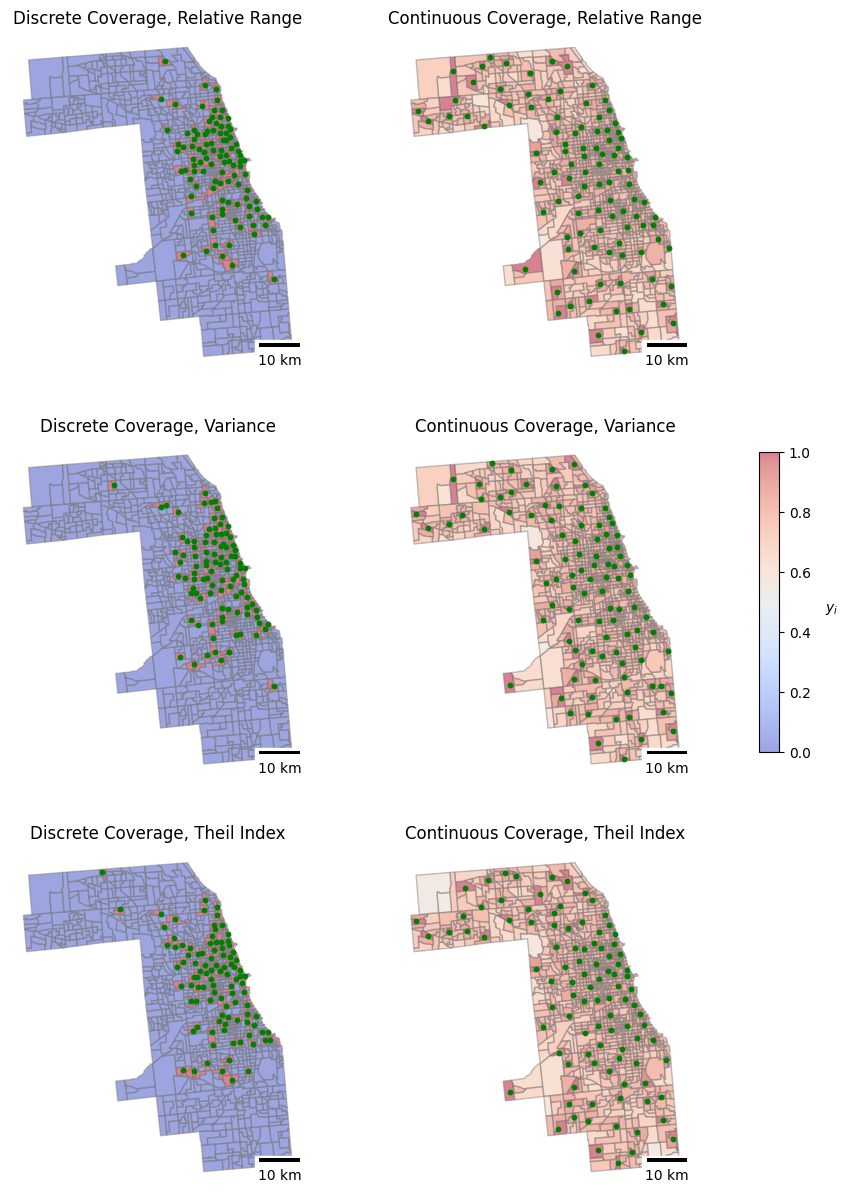

In [19]:
# MOO
s = 1000
t = 0.1

cook_centroids = gpd.read_file('data/cook_centroids_all.shp')
cook = gpd.read_file('data/cook_tract_all.shp')
n1 = cook_centroids.shape[0]

# discrete coverage
def coverage_discrete(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            if D[i, j] <= s:
                A[i, j] = 1
    return A

# continuous coverage
def coverage_continuous(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            A[i, j] = math.exp(-t * D[i, j] / s)
    return A

# distance matrix
points = cook_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
D = cdist(points, points, metric='euclidean')

C = {
    1: coverage_discrete,
    2: coverage_continuous
}
C_labels = ["Discrete Coverage", "Continuous Coverage"]
G = ["Sex", "Age", "Race", "Household Income"]
P = ["Relative Range", "Variance", "Theil Index"]

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for idx_c, cov in enumerate(C):
    A = C[cov](n1, D)
    for idx_p, prob in enumerate(P):
        ax = axs[idx_p, idx_c]
        F = pickle.load(open('data/obj/F_cov' + str(idx_c+1) + '_grp2' + '_prob' + str(idx_p+1) + '.pickle', "rb"))
        X = pickle.load(open('data/sols/X_cov' + str(idx_c+1) + '_grp2' + '_prob' + str(idx_p+1) + '.pickle', "rb"))
        max_index = np.argmax(-F[:, 0])
        X_moo = X[max_index]
        Y_moo = np.max(X_moo * A, axis=1)

        cook_centroids['moo'] = X_moo
        cook['moo'] = Y_moo
        moo_loc = cook_centroids[cook_centroids['moo'] != 0]

        cook.plot(ax=ax, column='moo', cmap='coolwarm', alpha=0.5, edgecolor='gray', vmin=0, vmax=1)
        moo_loc.plot(ax=ax, marker='o', color='g', markersize=10)
        ax.set_title(f"{C_labels[idx_c]}, {prob}")
        ax.set_axis_off()
        scalebar = ScaleBar(1, location='lower right')
        ax.add_artist(scalebar)

cax = fig.add_axes([0.92, 0.5 - 0.5 * 0.2, 0.02, 0.2])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # Dummy array for the colorbar
cbar = fig.colorbar(sm, cax=cax, alpha=0.5, shrink=0.5)
cbar.set_label('$y_i$', rotation=0, labelpad=15)

plt.subplots_adjust(wspace=0)
plt.savefig("moo_cov.png", format="png", bbox_inches='tight')
plt.savefig("moo_cov.eps", format="eps", bbox_inches='tight')
plt.show()


Coverage per group

In [30]:
s = 1000
t = 0.1

cook_centroids = gpd.read_file('data/cook_centroids_all.shp')
cook = gpd.read_file('data/cook_tract_all.shp')
n1 = cook_centroids.shape[0]

# discrete coverage
def coverage_discrete(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            if D[i, j] <= s:
                A[i, j] = 1
    return A

# continuous coverage
def coverage_continuous(n1, D):
    A = np.zeros((n1, n1))
    for i in range(n1):
        for j in range(n1):
            A[i, j] = math.exp(-t * D[i, j] / s)
    return A

# distance matrix
points = cook_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
D = cdist(points, points, metric='euclidean')

C = {
    1: coverage_discrete,
    2: coverage_continuous
}
C_labels = ["Discrete Coverage", "Continuous Coverage"]
G = ["Sex", "Age", "Race", "Household Income"]
P = ["Relative Range", "Variance", "Theil Index"]
groups = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
W = cook_centroids[groups].to_numpy()

for idx_c, cov in enumerate(C):
    A = C[cov](n1, D)
    X_mclp = pickle.load(open('data/sols/X_cov' + str(cov) + '.pickle', "rb"))
    Y_mclp = np.max(X_mclp * A, axis=1)
    U = [np.sum(Y_mclp * W.T, axis=1) / np.sum(W, axis=0)]

    for idx_p, prob in enumerate(P):
        F = pickle.load(open('data/obj/F_cov' + str(idx_c+1) + '_grp2' + '_prob' + str(idx_p+1) + '.pickle', "rb"))
        X = pickle.load(open('data/sols/X_cov' + str(idx_c+1) + '_grp2' + '_prob' + str(idx_p+1) + '.pickle', "rb"))
        max_index = np.argmax(-F[:, 0])
        X_moo = X[max_index]
        Y_moo = np.max(X_moo * A, axis=1)
        u_k_moo = np.sum(Y_moo * W.T, axis=1) / np.sum(W, axis=0)
        U.append(u_k_moo)

    print(U)

[array([0.39026205, 0.43930333, 0.55079706, 0.44468648, 0.5076    ,
       0.57366555, 0.51106423]), array([0.39044804, 0.3944979 , 0.43623482, 0.41566051, 0.4036    ,
       0.43953999, 0.43959993]), array([0.38414376, 0.394133  , 0.41434717, 0.40724283, 0.3916    ,
       0.42690284, 0.4159153 ]), array([0.39574293, 0.4056568 , 0.42952935, 0.41786118, 0.4108    ,
       0.42690828, 0.42405742])]
[array([0.8569345 , 0.86108592, 0.86721883, 0.86071483, 0.85453661,
       0.86876146, 0.86564941]), array([0.85450165, 0.85425045, 0.86230467, 0.85456289, 0.85778075,
       0.86220247, 0.86192676]), array([0.85592023, 0.85494397, 0.86151283, 0.86058553, 0.85252926,
       0.86055038, 0.85989777]), array([0.85627033, 0.85273767, 0.86476072, 0.86049291, 0.85741145,
       0.86031144, 0.86241818])]


Sensitivity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


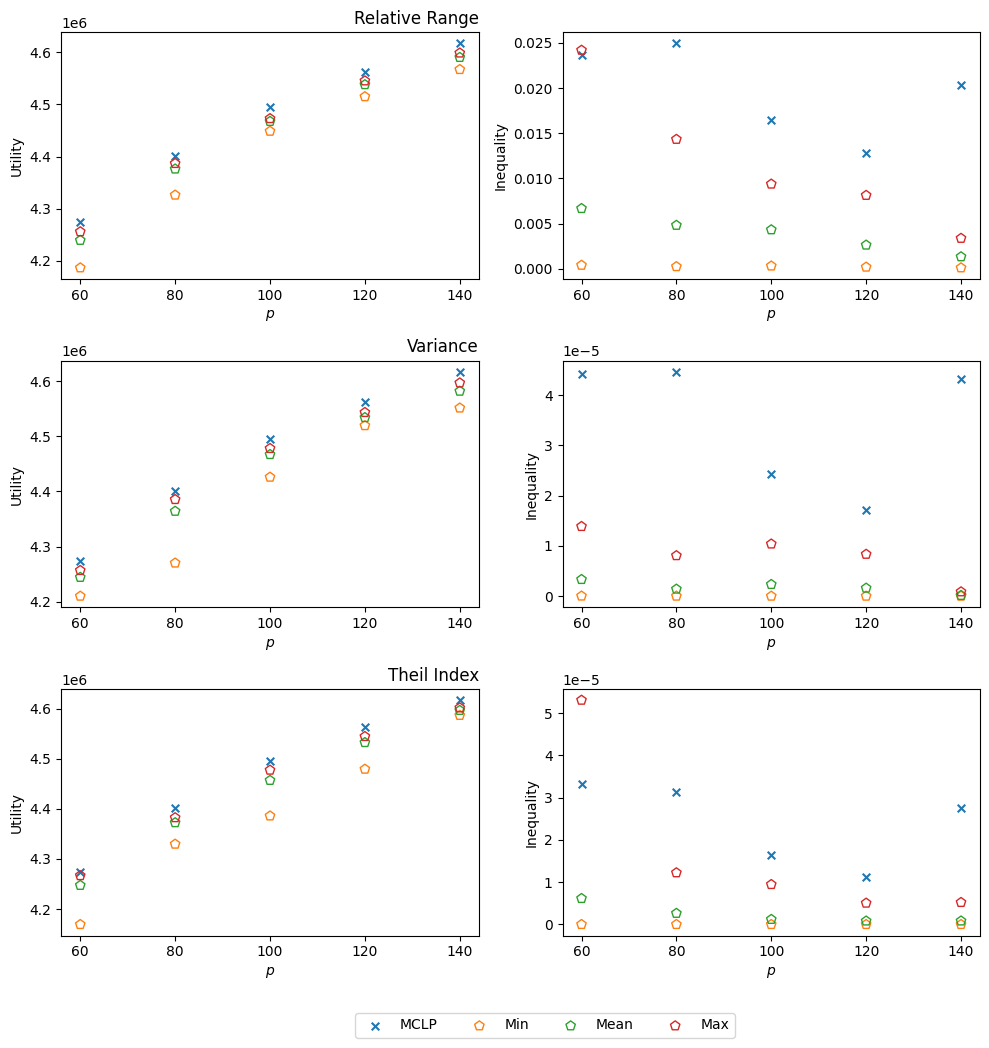

In [55]:
P = ["Relative Range", "Variance", "Theil Index"]
p_all = [60, 80, 100, 120, 140]

cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for idx_prob, prob in enumerate(P):
    mclp_u, mclp_e  = [], []
    moo_u_min, moo_u_mean, moo_u_max  = [], [], []
    moo_e_min, moo_e_mean, moo_e_max  = [], [], []

    for p in p_all:
        F_mclp = pickle.load(open('data/obj/F_p' + str(p) + '.pickle', "rb")) 
        mclp_u.append(-F_mclp[0])
        mclp_e.append(F_mclp[idx_prob+1])

        F_moo = pickle.load(open('data/obj/F_p' + str(p) + '_prob' + str(idx_prob+1) + '.pickle', "rb")) 
        u, e = -F_moo[:, 0], F_moo[:, 1]
        moo_u_min.append(np.min(u))
        moo_u_mean.append(np.mean(u))
        moo_u_max.append(np.max(u))

        moo_e_min.append(np.min(e))
        moo_e_mean.append(np.mean(e))
        moo_e_max.append(np.max(e))


    ax1 = axs[idx_prob, 0]
    ax1.scatter(p_all, mclp_u, s=30, marker='x', label="MCLP", color=cmap(0))
    ax1.scatter(p_all, moo_u_min, s=50, marker="p", label="Min", facecolors='none', edgecolors=cmap(1))
    ax1.scatter(p_all, moo_u_mean, s=50, marker="p", label="Mean", facecolors='none', edgecolors=cmap(2))
    ax1.scatter(p_all, moo_u_max, s=50, marker="p", label="Max", facecolors='none', edgecolors=cmap(3))
    ax1.set_xlabel("$p$")
    ax1.set_ylabel("Utility")
    ax1.set_xticks(p_all)
    ax1.set_title(prob, loc='right')

    ax2 = axs[idx_prob, 1]
    ax2.scatter(p_all, mclp_e, s=30, marker='x', label="MCLP", color=cmap(0))
    ax2.scatter(p_all, moo_e_min, s=50, marker="p", label="Min", facecolors='none', edgecolors=cmap(1))
    ax2.scatter(p_all, moo_e_mean, s=50, marker="p", label="Mean", facecolors='none', edgecolors=cmap(2))
    ax2.scatter(p_all, moo_e_max, s=50, marker="p", label="Max", facecolors='none', edgecolors=cmap(3))
    ax2.set_xlabel("$p$")
    ax2.set_ylabel("Inequality")
    ax2.set_xticks(p_all)

fig.legend(["MCLP", "Min", "Mean", "Max"], loc='lower center', bbox_to_anchor=(0.55, -0.05), ncol=4)
plt.tight_layout()
plt.savefig("sensitivity.eps", format="eps", bbox_inches='tight')
plt.show()

Runtime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


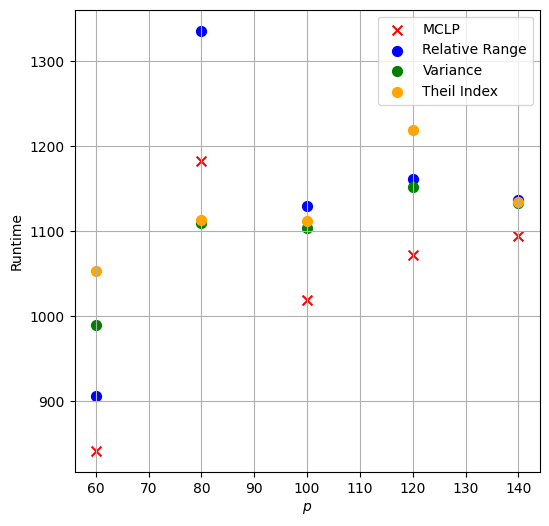

In [84]:
df = pd.read_csv("data/runtime.csv")

custom_order = ['MCLP', 'Relative Range', 'Variance', 'Theil Index']

# Set 'prob' column as Categorical with custom order
df['prob'] = pd.Categorical(df['prob'], categories=custom_order, ordered=True)

# Sort DataFrame based on 'prob' column
df = df.sort_values('prob')

# Define colors for each prob
colors = {'MCLP': 'red', 'Relative Range': 'blue', 'Variance': 'green', 'Theil Index': 'orange'}

# Create a scatter plot
plt.figure(figsize=(6, 6))
handles = []  # Store legend handles

for prob, group in df.groupby('prob'):
    if prob == 'MCLP':
        handles.append(plt.scatter(group['p'], group['runtime'], label=f'{prob}', color=colors[prob], s=50, marker='x'))
    else:
        handles.append(plt.scatter(group['p'], group['runtime'], label=f'{prob}', color=colors[prob], s=50))

plt.xlabel('$p$')
plt.ylabel('Runtime')
plt.legend(handles=handles)
plt.grid(True)
plt.savefig("runtime.eps", format="eps", bbox_inches='tight')
plt.show()

In [82]:
df.groupby('prob')